# Raport z projektu zaliczeniowego: Analiza Danych Niekompletnych (2026)

AUTHORS: <br>
Martyna Dudek (84869) <br>
Piotr Wilma (84875)

Link do pełnego repozytorium: https://github.com/Wilsonuep/incomplete-data-coding-final

**1. Wstęp**

W ramch projketu opracowalśmy model regresyjny do prognozowania cen wynajmu mieszkań w Poznaniu. Zastosowaliśmy biblioteki LightGBM oraz XGBoost wsparte imputacją braków danych (KNN), encodingiem cech kategorycznych oraz transformacją logarytmiczną zmiennej celu. Nasza grupa na Kaggle nazywała się Martyna & Piotr (#3) z wynikiem 78508.79 uzyskanym LightGBM. <br>
W przygotowaniu projektu wykorzystaliśmy głównie Perplexity (z automatycznym doborem modelu) do researchu oraz Claude Sonnet 4.5 do optymalizacji pojedynczych fragmentów kodu oraz dodawania komentarzy.

**2. Metodyka**

2.1 Przygotowanie danych zaczeliśmy od standaryzacji i oczyszczenia zbioru z błędnych wartości. <br>
 - Zidentyfikowaliśmy wartości -999 oraz -9, które w zbiorze służyły jako oznaczenie braków danych. Zostały one zmienone na NAN, aby umożliwić poprawną imputację.
 - Stworzyliśmy pętlę weryfikującą poprawność danych numerycznych, gdzie wszytskie wartości ujemne zmienione zostały na brak danych.

2.2 Następnie zastosowalismy dwuetapową imputcję danych. <br>
- Na początku odzyskaliśmy dane z tytułów ogłoszeń. Stworzyliśmy funkcję opartą na wyrażeniach reguralnych, które wyodrębniały z tekstu np. powierzchnię. Pozwoliło nam to uzupełnić 400 braków w flat_area, 1531 w flat_rooms oraz 569 w quarter.
- Podzieliśmy również dane dotyczące dat na osobne kolumny łatwiejsze do nauki modelu i bardziej generalizujące okres a nie konkretny dzień. Mogło to pomóc w lepszym generalizowaniu czasu i uchwycenia pewnych trendów cyklicznych.
- Dla pozostałych danych numerycznych oraz kategorycznych, których nie udało się odzyskać zastosowano algorytmy, które zostały wybrane za pomocą funkcji testującej metody imputacji i weryfikującej ich dokładność za pomocą średnich odchyleń od znanych wartości, na których były testowane.
    - Zmienne numeryczne uzupełniono za pomocą KNN, gdzie braki uzupełniano średnią wartością od 5 najbardziej podobnych sąsiadów.
    - Dla zmiennych binarnych zastosowano imputację opartą na regresji logistycznej, która dla każdej cechy trenowała oddzielny model klasyfikacyjny. Braki przewidywano na podsatwie parametrów fizycznych, a w przypadkach, w których model nie mógł zadziałać stosowano modę.
    - Do imputacji zmiennej quarter opracowano dedykowaną procedurę imputacji opartą na KNN. Dzielnice zostały zakodowane numerycznie, a brakujące wartości oszacowano na podstawie 5 najbardziej podobnych ofert.

2.3 Przed trenowaniem modeli dokonaliśmy analizy rozkładu zmiennej celu (price), która wykazała silną skośność prawostronną (drogie apartamenty jako wartości odstające). Aby poprawić stabilnośc procesu oraz zminimalizować wpływ outlinerów zastosowalismy transformację logistyczną dla części modeli, która później okazała się nieskuteczna. W implementacji wykorzystano wrapper TransformedTargetRegressor z biblioteki Scikit-learn. Pozwoliło to na automatyczne logarytmowanie danych treningowych oraz przekształcenie predykcji do oryginalnej skali cenowej, co uprościło przetwarzanie oraz ewaluacje.

2.4 W etapie modelowania zastosowaliśmy algorytmy oparte na wzmacnianiu gradientowym, w tym XGBoost oraz LightGBM w różnych konfiguracjach sprawdzanych za pomocą wielokrotnych iteracji RandomizedSearchCV oraz GridSearchCV wraz z walidacją krzyżową na ustawionym ziarnie. Pętle uczenia są zakomentowane aby kod dało się odtworzyć z lekkością a częściowo wyniki zostały zapisane w pliku folds_history.csv. Ostatecznie najlepsze rezultaty osiągnięto przy użyciu LightGBM bez logarytmicznej transformacji zmiennej celu. Model ten wykazał się wysoką skutecznością predykcji danych przez prawdopodne mniejsze przeuczenie charakterystyczne dla modeli XGBoost. 

**3. Wyniki**

3.1 W trakcie prac nad projketem przetestowliśmy cztery główne konfiguracje modeli, gdzie miarą błędu było RMSE. Najlepsze uzyskane wyniki z każdego modelu przedstawia tabela poniżej. Wyniki były sprawdzanę raz - dodaliśmy predykcję z naszych 4 najlepszych modeli.

| Model | Konfiguracja | Wynik (RMSE) | Komentarz |
| :--- | :--- | :--- | :--- |
| **XGBoost** | Baseline, domyślne parametry | **80121.76** | Dobry punkt wyjścia. |
| **XGBoost_log** | Transformacja logarytmiczna celu | **81842.94** | Zastosowanie logarytmizacji pogorszyła wynik. |
| **LightGBM_log** | Transformacja logarytmiczna celu | **81987.70** | Transformacja również nie przyniosła poprawy. |
| **LightGBM** | **Brak transformacji, learning_rate=0.05** | **78508.79** | Odpowiednie dostrojenie dało najmniejszy błąd predykcji |

3.2 Proces dochodzenia do najlepszego wyniku przebiegał wieloetapowo.
- Baseline: Uruchomienie modelu XGBoost na domyślnych parametrach pozwolił ustalić punkt odniesienia z wynikiem RMSE na poziomie 80121. Był to dobry start, który wskazywał możliwość dalszej optymalizacji. 
- Zastosowanie transformacji: W celu zniwelowania skośności rozkładu cen zastosowaliśmy transformację logarytymiczną. Ku naszemu zaskoczeniu zabieg ten pogorszył wynik dla obu testowanych przez nas algorytmów. Sugeruje nam to, że błędy estymacji popełniane na skali logarytmicznej, po powrotym prszekształceniu uległy wzmocnieniu. Wynika z tego, że transformacja okazała się niekorzystna.
- Zmiana na LightGBM i optymalizacja: Mimo braku poprawy po transformacji danych zmiana algorytmu na LightGBM na surowych danych pzyniosła poprawę. Dzięki szybszemu procesowi uczenia mogliśmy przetestować większy zakres hiperparametrów. Uproszczenie modelu pozwoliło na lepsze dopasowanie do predykcji.
- Ostateczna konfiguracja: Odpowiednio wyregulowany model gradientowy potrafił samodzielnie i skutecznie zamodelować dane surowe, bez konieczności stosowania transformacji matematycznych. Dzięki temu model LightGBM uzyskał wynik o ponad 1000 RMSE niższy od baseline'u.

**4. Podsumowanie**

Realizacja projektu dostarczyła kilku kluczowych informacji. Największym zaskoczeniem był fakt, że transformacja logarytmiczna zmiennej celu pogorszyła wyniki. Nauczyło nas to, że teoretyczne założenia (o normalizacji rozkładu cen) należy zawsze weryfikować eksperymentalnie. Dobrze dostrojony model na surowych danych (LightGBM) poradził sobie lepiej z wartościami odstającymi niż model z wymuszoną transformacją. Dodatkowo kluczem do sukcesu nie był sam algorytm, ale przygotowanie danych. "Uratowanie" wielu rekordów poprzez wyciągnięcie ichz tytułów ogłoszeń dało modelowi więcej informacji niż jakakolwiek zmiana hiperparametrów. Co prowadzi nas do wniosków, że prawidłowa imputacja danych jest kluczowa do stworzenia dobrego modelu. Uzupełnienie ich za pomocą Regex czy KNN, zamiast usuwania braków pozwoliło nam zachować wiele rekordów co przy modelowaniu ceny było bardzo pomocne.

**5. Kod do odtworzenia wyników**

Ładowanie pakietów

In [ ]:
# Biblioteki do analizy danych i wizualizacji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Biblioteki do przetwarzania danych
import numpy as np
import re

# Biblioteki do uczenia maszynowego
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder 
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
import lightgbm as lgb

/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ładowanie danych - proszę podmienić ścieżkę do pliku z danymi treningowymi i testowymi

In [ ]:
train_data_path = "data/pzn-rent-train.csv"
test_data_path = "data/pzn-rent-test.csv"

In [ ]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

Analiza eksploracyjna danych

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11297 entries, 0 to 11296
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11297 non-null  int64  
 1   ad_title            11297 non-null  object 
 2   date_activ          11297 non-null  object 
 3   date_modif          11297 non-null  object 
 4   date_expire         11297 non-null  object 
 5   individual          10194 non-null  object 
 6   price               11297 non-null  int64  
 7   flat_area           10080 non-null  float64
 8   flat_rooms          10070 non-null  float64
 9   flat_furnished      9980 non-null   object 
 10  flat_rent           11297 non-null  int64  
 11  flat_deposit        11297 non-null  float64
 12  flat_for_students   9493 non-null   object 
 13  building_floor_num  11297 non-null  int64  
 14  flat_balcony        9929 non-null   object 
 15  flat_utility_room   11297 non-null  bool   
 16  flat

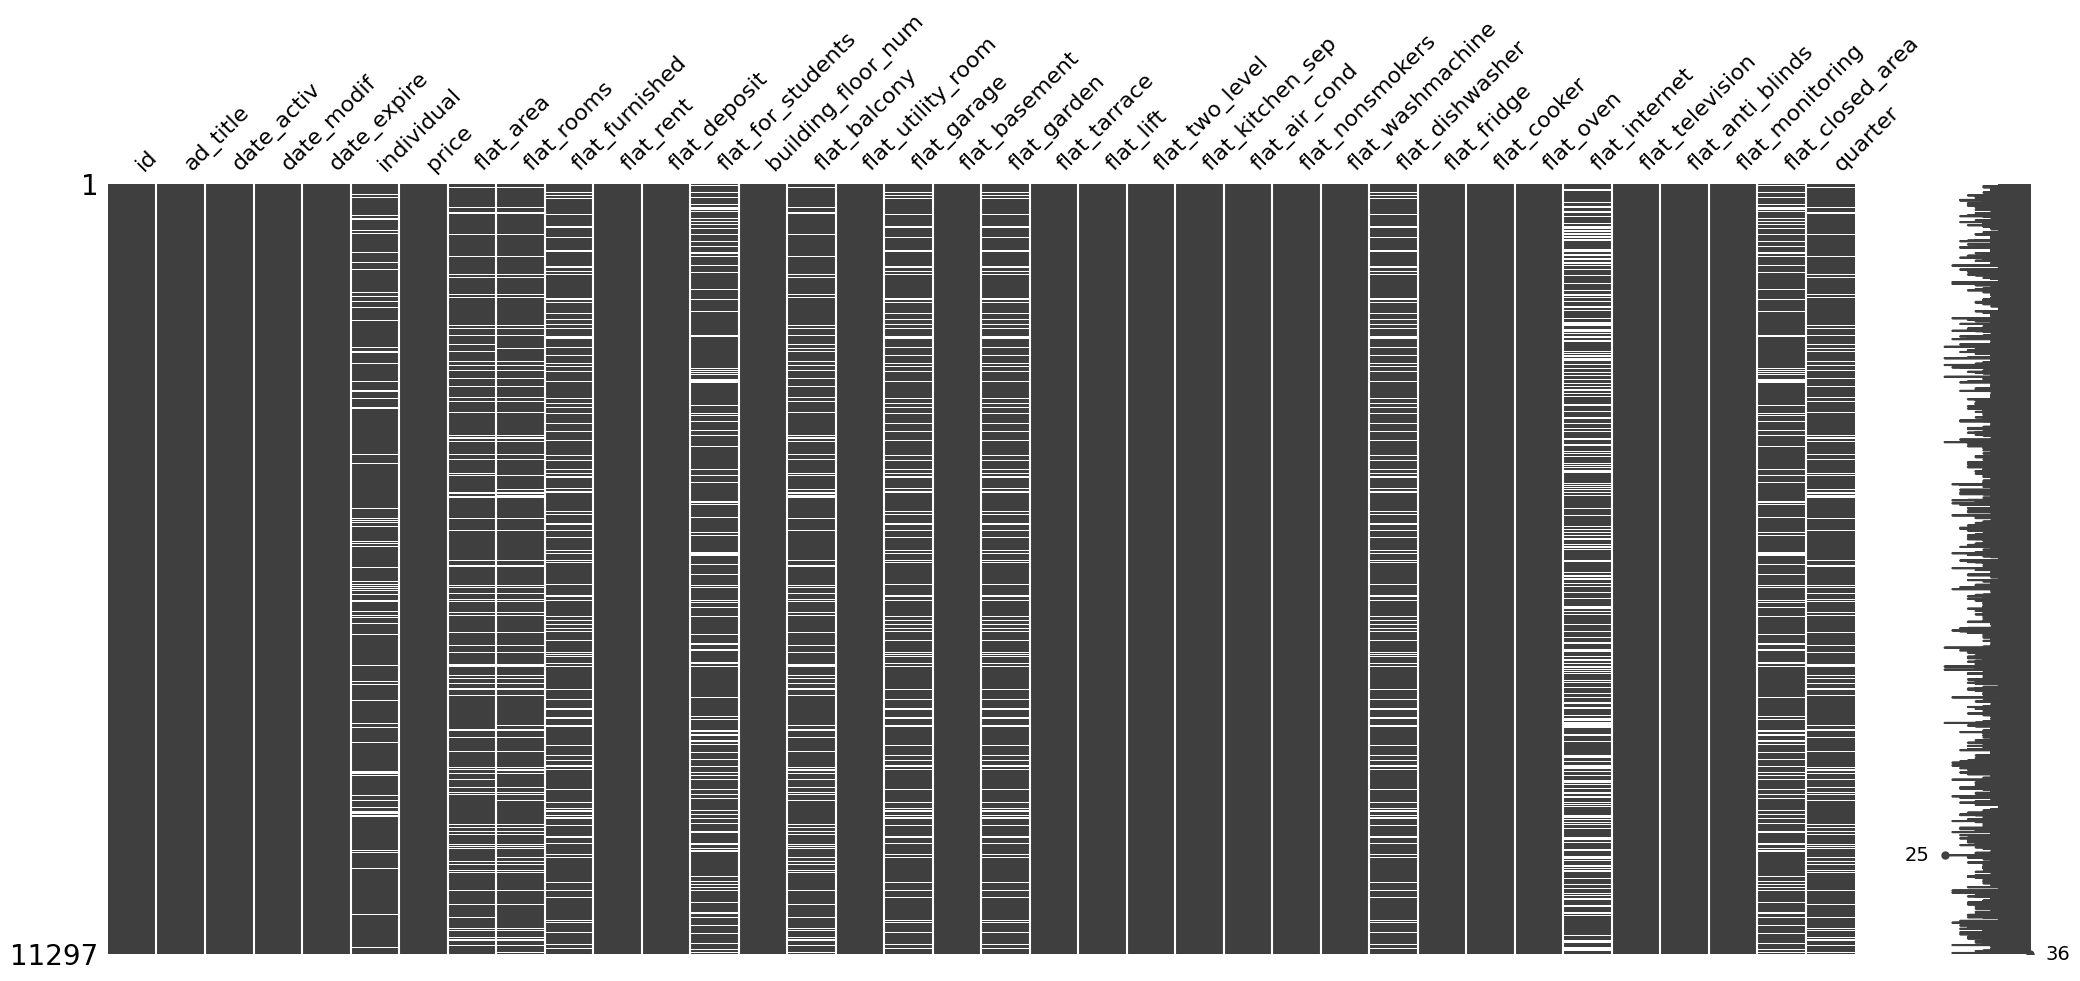

In [ ]:
msno.matrix(train)
plt.show()

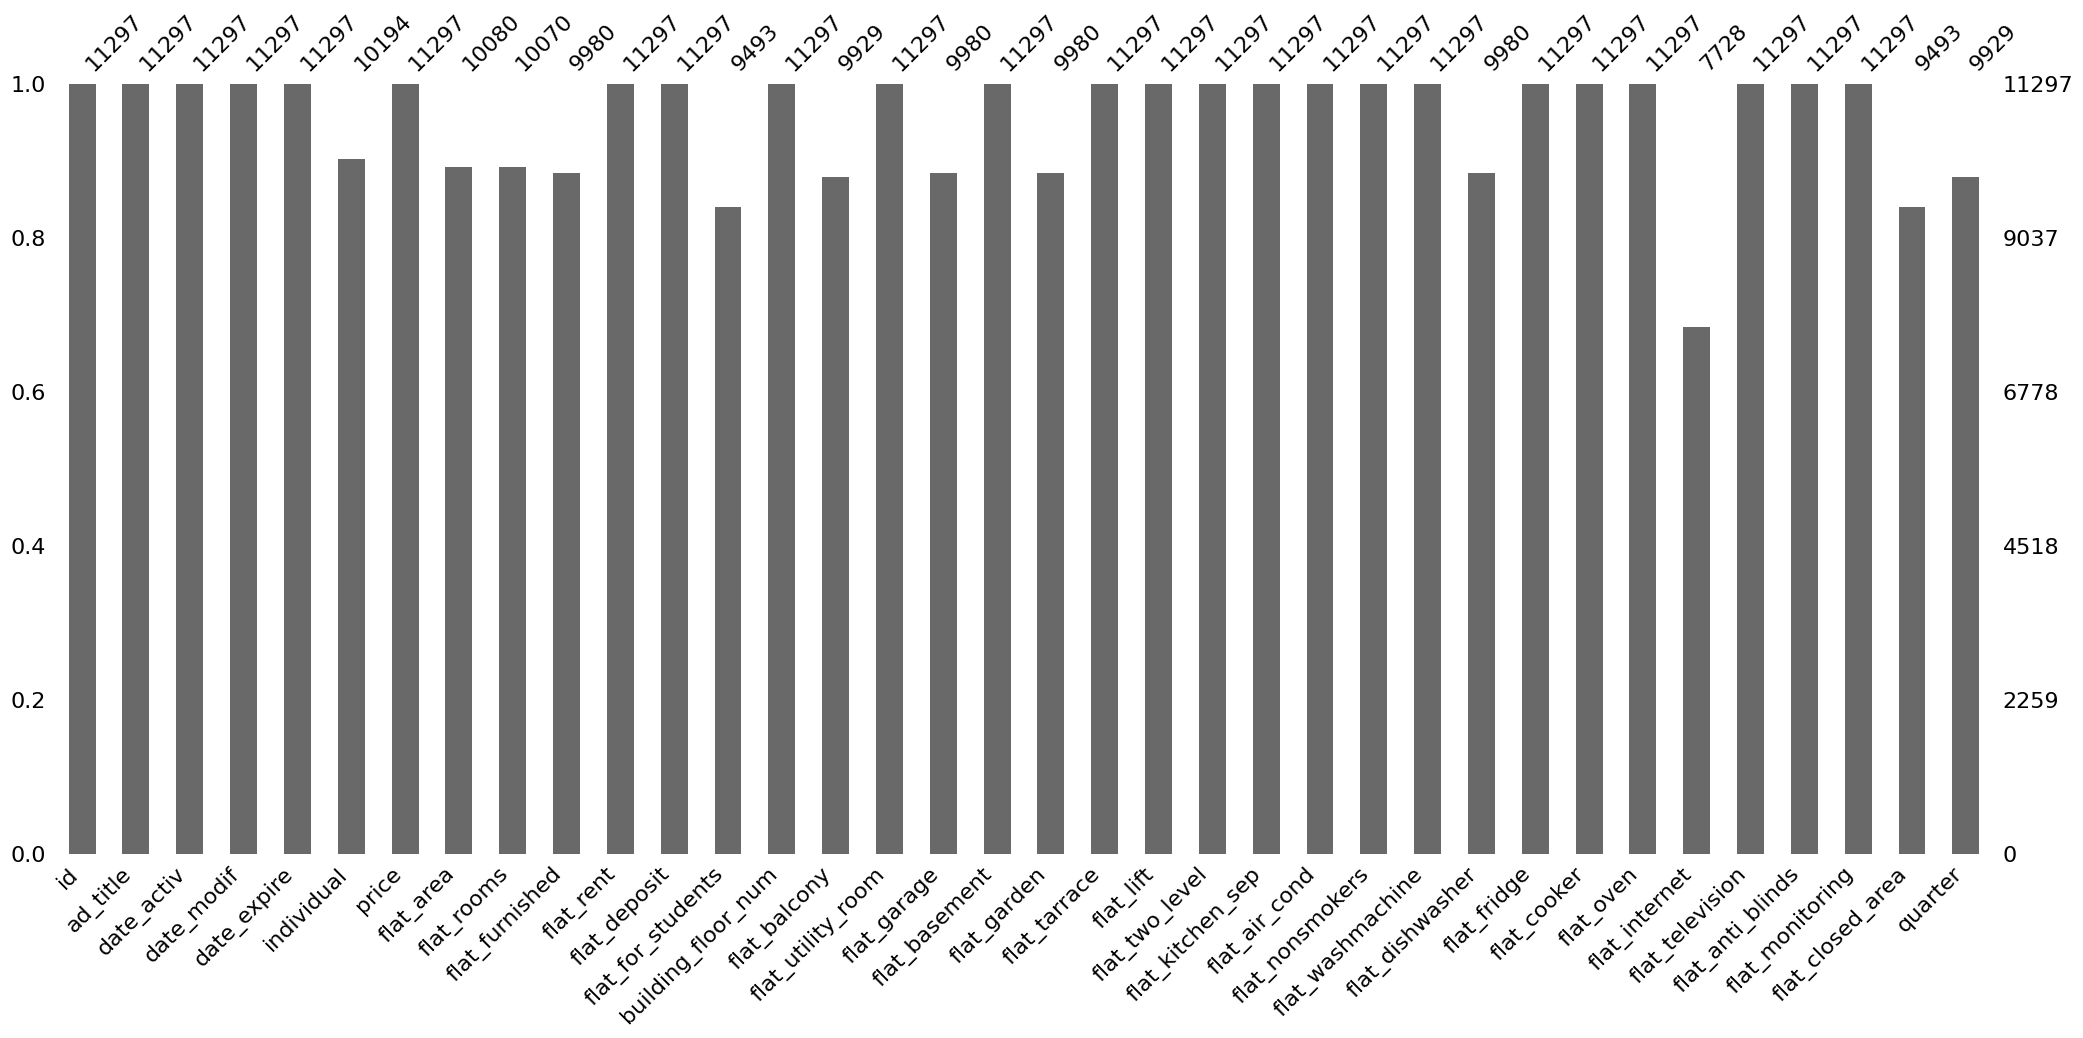

In [ ]:
msno.bar(train)
plt.show()

In [ ]:
sns.set_theme(style="whitegrid", palette="mako_r")

<Axes: >

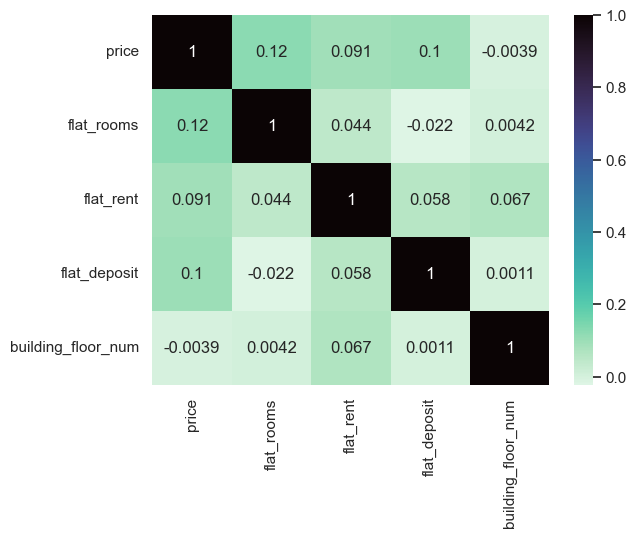

In [ ]:
sns.heatmap(train[['price', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']].corr(), annot=True, cmap='mako_r')

/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


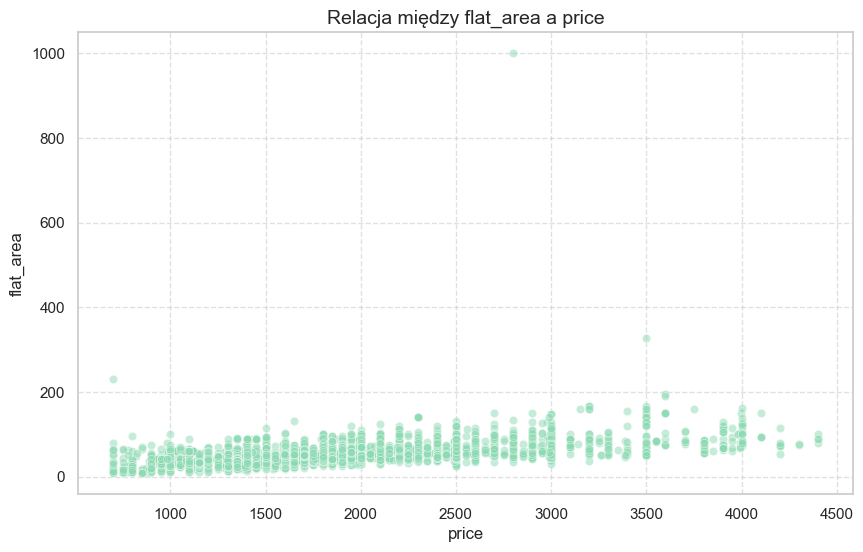

/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


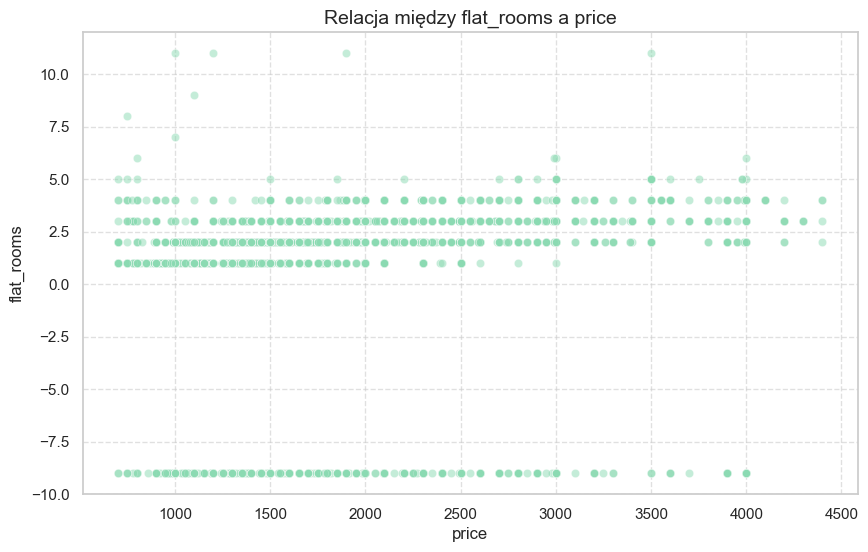

/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/utils.py:105: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/Users/piotr/incomplete-data-coding-final/.venv/lib/python3.12/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


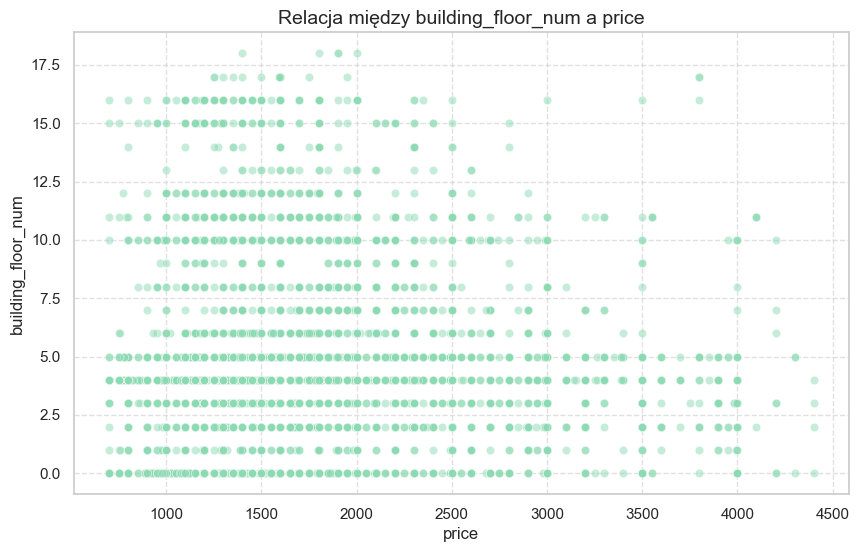

In [ ]:
train = train.replace(-999, np.nan)

cols_to_plot = ['flat_area', 'flat_rooms', 'building_floor_num']

for col in cols_to_plot:
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=train, x='price', y=col, alpha=0.5, cmap='mako_r')
    
    plt.title(f'Relacja między {col} a price', fontsize=14)
    plt.xlabel(f'price', fontsize=12)
    plt.ylabel(f'{col}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

In [ ]:
print(train['flat_rent'].describe())
print(train['flat_deposit'].describe())

count    11297.000000
mean       286.686642
std        542.004637
min          0.000000
25%          0.000000
50%        310.000000
75%        460.000000
max      50000.000000
Name: flat_rent, dtype: float64
count     11297.000000
mean       1300.089820
std        5784.663857
min           0.000000
25%           0.000000
50%        1400.000000
75%        2000.000000
max      600067.000000
Name: flat_deposit, dtype: float64


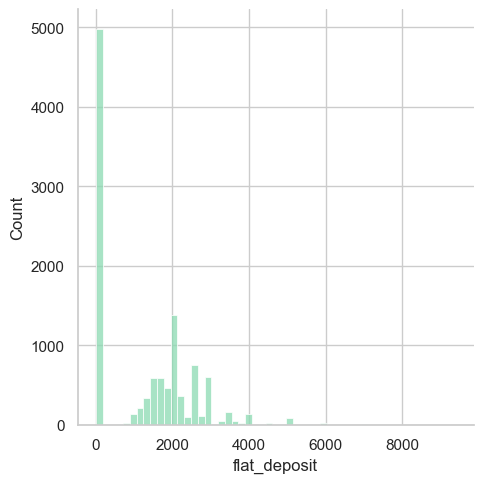

In [ ]:
sns.displot(
    data=train[train['flat_deposit'] < 10000], 
    x='flat_deposit', 
    bins='auto'
)
plt.show()

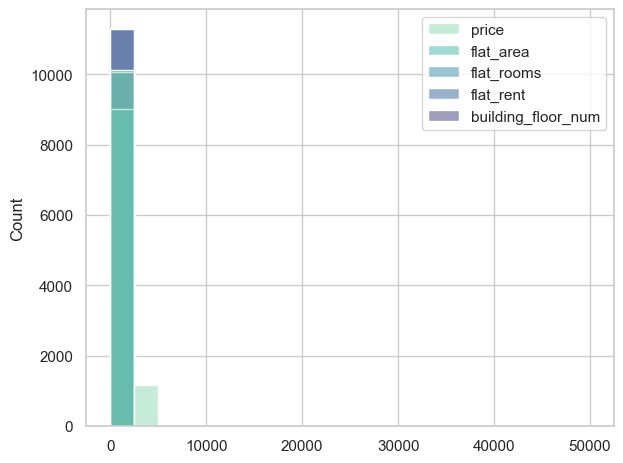

In [ ]:
sns.histplot(
    data = train.select_dtypes(include='number').drop(columns=['id', 'flat_deposit']),
    bins=20
)
plt.tight_layout()
plt.show()

Data cleaning and imputation

In [ ]:
train = train[~((train['flat_area'] > 900) & (train['price'] < 3500))]
train = train[~((train['flat_rooms'] >= 8) & (train['flat_rooms'] < 0))]

In [ ]:
def extract_area_from_title(title):
    """Wyodrębnia powierzchnię mieszkania z tytułu ogłoszenia używając regex"""
    if pd.isna(title):
        return np.nan
    
    # Wzorce: "10 m2", "10.5 m2", "10,5 mkw", "10metrów"
    match = re.search(r'(\d+[.,]?\d*)\s*(m2|mkw|metr|m²|sqm)', str(title), re.IGNORECASE)
    
    if match:
        res = match.group(1).replace(',', '.') 
        try:
            return float(res)
        except:
            return np.nan
    return np.nan

In [ ]:
train['flat_area'] = train['flat_area'].replace(-999, np.nan)

extracted_areas = train['ad_title'].apply(extract_area_from_title)

missing_before = train['flat_area'].isna().sum()
can_fix = (train['flat_area'].isna() & extracted_areas.notna()).sum()

train['flat_area'] = train['flat_area'].fillna(extracted_areas)

print(f"Liczba braków przed: {missing_before}")
print(f"Liczba uzupełnionych: {can_fix}")
print(f"Liczba braków po operacji: {train['flat_area'].isna().sum()}")


print(test['flat_area'].describe())

Liczba braków przed: 2286
Liczba uzupełnionych: 400
Liczba braków po operacji: 1886
count    4335.000000
mean      -66.113749
std       330.067254
min      -999.000000
25%        34.000000
50%        45.000000
75%        54.000000
max      2200.000000
Name: flat_area, dtype: float64


In [ ]:
missing_flat_area = test[test['flat_area'].isna()]

print(missing_flat_area[['ad_title', 'flat_area']].head(30))

                                              ad_title  flat_area
1      Kawalerka Poznań Rataje niska zabudowa 2 piętro        NaN
2           Kawalerka, w szeregowcu z osobnym wejściem        NaN
14                           Mieszkanie, 32 m², Poznań        NaN
21    kawalerka po remoncie Jasna Rola 36 bezpośrednio        NaN
32   Wynajmę wyremontowane umeblowane mieszkanie - ...        NaN
33         wynajmę ładny APARTAMENT kawalerkę Grunwald        NaN
46      Poznań ul. Hawelańska - Kawalerka do wynajęcia        NaN
47     Atrakcyjne mieszkanie w kamienicy, niski czynsz        NaN
52         Mieszkanie Poznań Grunwald, ul. Wojskowa 3b        NaN
54                             kawalerka w sercu Jeżyc        NaN
58         Mieszkanie wynajem kawalerka, 20 m², Poznań        NaN
59             Wynajmę piękną kawalerkę na Winogradach        NaN
61     Mieszkanie w centrum Poznania - bez pośredników        NaN
63                  wynajmę ładną kawalerkę APARTAMENT        NaN
66        

In [ ]:
def extract_rooms_from_title(title):
    """Wyodrębnia liczbę pokoi z tytułu ogłoszenia"""
    if pd.isna(title):
        return np.nan
    title_str = str(title).lower()
    
    # Rozpoznawanie kawalerki/studia jako 1 pokój
    if 'kawalerka' in title_str or 'studio' in title_str:
        return 1.0
    
    # Szukanie liczby przed słowem "pok"
    match = re.search(r'(\d+)\s*(?:[a-ząćęłńóśźż]+\s+)?-?pok', title_str)
    if match:
        return float(match.group(1))
    
    return np.nan

In [ ]:
train['flat_rooms'] = train['flat_rooms'].replace(-9, np.nan)
extracted_rooms = train['ad_title'].apply(extract_rooms_from_title)

can_fix_rooms = (train['flat_rooms'].isna() & extracted_rooms.notna()).sum()
train['flat_rooms'] = train['flat_rooms'].fillna(extracted_rooms)

print(f"Uzupełniono flat_rooms: {can_fix_rooms}")
print(f"Liczba braków po operacji: {train['flat_rooms'].isna().sum()}")

Uzupełniono flat_rooms: 1531
Liczba braków po operacji: 807


In [ ]:
missing_flat_rooms = train[train['flat_rooms'].isna()]

print(missing_flat_rooms[['ad_title', 'flat_rooms']].head(30))

                                              ad_title  flat_rooms
18       Poznań Malta- mieszkanie do wynajęcia + garaż         NaN
86                                   Pokoje Na Wynajem         NaN
128                        Piękne mieszkanie w centrum         NaN
143  Winogrady, Wilczak umeblowane, z widokiem na W...         NaN
162                        Nowe mieszkanie na Jeżycach         NaN
179   Nowoczesne, świeżo wykończone, parking + komórka         NaN
180    Poznań Przybyszewskiego, doskonała lokalizacja.         NaN
209                Grunwald Uniwersytet Medyczny Garaż         NaN
217                    Ładne Mieszkanie Na Strzeszynie         NaN
227                          Mieszkanie, 60 m², Poznań         NaN
228                          Mieszkanie, 46 m², Poznań         NaN
234                          Mieszkanie, 20 m², Poznań         NaN
252             Mieszkanie z balkonem ul. Dominikańska         NaN
256             Nowoczesne mieszkanie w nowym obiekcie        

In [ ]:
unique_quarters = train['quarter'].dropna().unique().tolist()
unique_quarters = sorted(unique_quarters, key=len, reverse=True)

In [ ]:
def fill_quarter_from_title(row):
    if pd.notna(row['quarter']):
        return row['quarter']
    
    title = str(row['ad_title']).lower()
    for q in unique_quarters:
        if q.lower() in title:
            return q 
    return np.nan 

In [ ]:
before_train = train['quarter'].isna().sum()
train['quarter'] = train.apply(fill_quarter_from_title, axis=1)
after_train = train['quarter'].isna().sum()

print(f"Uzupełniono {before_train - after_train} braków.")

Uzupełniono 569 braków.


In [ ]:
def evaluate_imputation_methods(df, target_col, predictor_cols):
    """
    Testuje różne metody imputacji i zwraca błędy RMSE dla każdej metody.
    Używa train-test split do symulacji braków danych.
    """
    # Dane kompletne (bez braków)
    data_complete = df.dropna(subset=[target_col] + predictor_cols).copy()
    
    X = data_complete[predictor_cols]
    y = data_complete[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}
    
    # Testowanie różnych metod: średnia, mediana, regresja, KNN
    
    #Średnia globalna
    y_pred_mean = np.full_like(y_test, y_train.mean())
    results['Średnia'] = np.sqrt(mean_squared_error(y_test, y_pred_mean))

    #Mediana globalna
    y_pred_med = np.full_like(y_test, y_train.median())
    results['Mediana'] = np.sqrt(mean_squared_error(y_test, y_pred_med))

    #Regresja Liniowa 
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    results['Regresja'] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    #KNN 
    knn = KNNImputer(n_neighbors=5)
    
    test_hidden = X_test.copy()
    test_hidden[target_col] = np.nan
    train_full = pd.concat([X_train, y_train], axis=1)
    
    
    imputed_data = knn.fit(train_full).transform(pd.concat([test_hidden, y_test.to_frame()], axis=0))
    y_pred_knn = imputed_data[:len(y_test), -1]
    results['KNN (k=5)'] = np.sqrt(mean_squared_error(y_test, y_pred_knn))

    return results

In [ ]:
area_eval = evaluate_imputation_methods(train, 'flat_area', ['flat_rooms', 'price'])
print("Błędy dla flat_area:", area_eval)


rooms_eval = evaluate_imputation_methods(train, 'flat_rooms', ['flat_area', 'price'])
print("Błędy dla flat_rooms:", rooms_eval)

Błędy dla flat_area: {'Średnia': np.float64(17.782131821410978), 'Mediana': np.float64(17.85118280630921), 'Regresja': np.float64(11.41457502632886), 'KNN (k=5)': np.float64(11.730579941313668)}
Błędy dla flat_rooms: {'Średnia': np.float64(0.8048945008408451), 'Mediana': np.float64(0.8076182210743118), 'Regresja': np.float64(0.5535518280167873), 'KNN (k=5)': np.float64(0.5503420795236196)}


In [ ]:
test.replace(-999, np.nan, inplace=True)
test.replace(-9, np.nan, inplace=True)
num_cols_test = test.select_dtypes(include=[np.number]).columns
for col in num_cols_test:
    test.loc[test[col] < 0, col] = np.nan

extracted_area_test = test['ad_title'].apply(extract_area_from_title)
test['flat_area'] = test['flat_area'].fillna(extracted_area_test)


extracted_rooms_test = test['ad_title'].apply(extract_rooms_from_title)
test['flat_rooms'] = test['flat_rooms'].fillna(extracted_rooms_test)

print("Brakujące wartości w zbiorze test")
print(test[['flat_area', 'flat_rooms']].isna().sum())

Brakujące wartości w zbiorze test
flat_area     800
flat_rooms    354
dtype: int64


In [ ]:
for df in [train, test]:
    df.replace([-999, -9], np.nan, inplace=True)
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df.loc[df[col] < 0, col] = np.nan
    
    df['flat_area'] = df['flat_area'].fillna(df['ad_title'].apply(extract_area_from_title))
    df['flat_rooms'] = df['flat_rooms'].fillna(df['ad_title'].apply(extract_rooms_from_title))

In [ ]:
# Imputacja braków za pomocą KNN (k=5 najbliższych sąsiadów)
impute_features = ['flat_area', 'flat_rooms', 'flat_rent']

imputer = KNNImputer(n_neighbors=5)

imputer.fit(train[impute_features])

train[impute_features] = imputer.transform(train[impute_features])

test[impute_features] = imputer.transform(test[impute_features])

train['flat_rooms'] = train['flat_rooms'].round()
test['flat_rooms'] = test['flat_rooms'].round()

print("Braki")
print(f"Train flat_area: {train['flat_area'].isna().sum()}")
print(f"Test flat_area: {test['flat_area'].isna().sum()}")

Braki
Train flat_area: 0
Test flat_area: 0


In [ ]:
print(train[['flat_area', 'flat_rooms']].describe())

          flat_area    flat_rooms
count  11296.000000  11296.000000
mean      47.503899      1.980613
std       17.359071      0.791766
min        7.000000      1.000000
25%       36.000000      1.000000
50%       46.000000      2.000000
75%       54.604000      2.000000
max      328.000000     11.000000


In [ ]:
print(train[['flat_area', 'flat_rooms']].head())

   flat_area  flat_rooms
0       49.0         2.0
1       65.0         3.0
2       30.0         1.0
3       10.0         1.0
4       47.0         2.0


In [ ]:
for df in [train, test]:
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df.loc[df[col] < 0, col] = np.nan
    
    df['flat_area'] = df['flat_area'].fillna(df['ad_title'].apply(extract_area_from_title))
    df['flat_rooms'] = df['flat_rooms'].fillna(df['ad_title'].apply(extract_rooms_from_title))

impute_features = ['flat_deposit', 'building_floor_num', 'flat_rent']

impute_features = [col for col in impute_features if col in train.columns and col in test.columns]


imputer = KNNImputer(n_neighbors=5)
imputer.fit(train[impute_features])

train[impute_features] = imputer.transform(train[impute_features])
test[impute_features] = imputer.transform(test[impute_features])

for col in ['building_floor_num']:
    if col in train.columns:
        train[col] = train[col].round()
        test[col] = test[col].round()

print("Pozostałe braki po imputacji KNN:")
print("Zbiór TRAIN:")
print(train[impute_features].isna().sum())
print("Zbiór TEST:")
print(test[impute_features].isna().sum())

Pozostałe braki po imputacji KNN:
Zbiór TRAIN:
flat_deposit          0
building_floor_num    0
flat_rent             0
dtype: int64
Zbiór TEST:
flat_deposit          0
building_floor_num    0
flat_rent             0
dtype: int64


In [ ]:
print(train[['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']].describe())

          flat_area    flat_rooms     flat_rent   flat_deposit  \
count  11296.000000  11296.000000  11296.000000   11296.000000   
mean      47.503899      1.980613    286.623495    1300.204913   
std       17.359071      0.791766    541.987070    5784.906988   
min        7.000000      1.000000      0.000000       0.000000   
25%       36.000000      1.000000      0.000000       0.000000   
50%       46.000000      2.000000    310.000000    1400.000000   
75%       54.604000      2.000000    460.000000    2000.000000   
max      328.000000     11.000000  50000.000000  600067.000000   

       building_floor_num  
count        11296.000000  
mean             4.295857  
std              3.094173  
min              0.000000  
25%              3.000000  
50%              4.000000  
75%              5.000000  
max             18.000000  


In [ ]:
print(train.columns)

Index(['id', 'ad_title', 'date_activ', 'date_modif', 'date_expire',
       'individual', 'price', 'flat_area', 'flat_rooms', 'flat_furnished',
       'flat_rent', 'flat_deposit', 'flat_for_students', 'building_floor_num',
       'flat_balcony', 'flat_utility_room', 'flat_garage', 'flat_basement',
       'flat_garden', 'flat_tarrace', 'flat_lift', 'flat_two_level',
       'flat_kitchen_sep', 'flat_air_cond', 'flat_nonsmokers',
       'flat_washmachine', 'flat_dishwasher', 'flat_fridge', 'flat_cooker',
       'flat_oven', 'flat_internet', 'flat_television', 'flat_anti_blinds',
       'flat_monitoring', 'flat_closed_area', 'quarter'],
      dtype='object')


In [ ]:
cat_cols_to_impute = ['individual', 'flat_furnished','flat_for_students', 'flat_balcony', 'flat_utility_room', 'flat_garage', 'flat_basement',
       'flat_garden', 'flat_tarrace', 'flat_lift', 'flat_two_level','flat_kitchen_sep', 'flat_air_cond', 'flat_nonsmokers',
       'flat_washmachine', 'flat_dishwasher', 'flat_fridge', 'flat_cooker','flat_oven', 'flat_internet', 'flat_television', 'flat_anti_blinds',
       'flat_monitoring', 'flat_closed_area']
predictors = ['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']

# Imputacja zmiennych binarnych za pomocą regresji logistycznej
cat_cols_to_impute = ['individual', 'flat_furnished', 'flat_for_students', ...]
predictors = ['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']
for target_col in cat_cols_to_impute:
    # Trenowanie modelu regresji logistycznej dla każdej cechy
    # Uzupełnienie braków predykcjami modelu
    # Pozostałe braki uzupełniane modą
    if target_col not in train.columns:
        continue
    
    train_complete = train.dropna(subset=[target_col] + predictors).copy()
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(train_complete[target_col].astype(str))
    X_train = train_complete[predictors]
    

    model_log = LogisticRegression(max_iter=1000)
    model_log.fit(X_train, y_train_encoded)
    

    mask_train = train[target_col].isna() & train[predictors].notna().all(axis=1)
    if mask_train.any():
        preds_train = model_log.predict(train.loc[mask_train, predictors])
        train.loc[mask_train, target_col] = le.inverse_transform(preds_train)
        

    mask_test = test[target_col].isna() & test[predictors].notna().all(axis=1)
    if mask_test.any():
        preds_test = model_log.predict(test.loc[mask_test, predictors])
        test.loc[mask_test, target_col] = le.inverse_transform(preds_test)


    mode_val = train[target_col].mode()[0]
    train[target_col] = train[target_col].fillna(mode_val)
    test[target_col] = test[target_col].fillna(mode_val)

print(f"Braki w TRAIN:\n{train[cat_cols_to_impute].isna().sum()}")
print(f"Braki w TEST:\n{test[cat_cols_to_impute].isna().sum()}")

Braki w TRAIN:
individual           0
flat_furnished       0
flat_for_students    0
flat_balcony         0
flat_utility_room    0
flat_garage          0
flat_basement        0
flat_garden          0
flat_tarrace         0
flat_lift            0
flat_two_level       0
flat_kitchen_sep     0
flat_air_cond        0
flat_nonsmokers      0
flat_washmachine     0
flat_dishwasher      0
flat_fridge          0
flat_cooker          0
flat_oven            0
flat_internet        0
flat_television      0
flat_anti_blinds     0
flat_monitoring      0
flat_closed_area     0
dtype: int64
Braki w TEST:
individual           0
flat_furnished       0
flat_for_students    0
flat_balcony         0
flat_utility_room    0
flat_garage          0
flat_basement        0
flat_garden          0
flat_tarrace         0
flat_lift            0
flat_two_level       0
flat_kitchen_sep     0
flat_air_cond        0
flat_nonsmokers      0
flat_washmachine     0
flat_dishwasher      0
flat_fridge          0
flat_cooker    

In [ ]:
def impute_quarter_knn(train, test):
    predictors = ['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']
    target = 'quarter'
    
  
    le = LabelEncoder()
    all_quarters = pd.concat([train[target].dropna(), test[target].dropna()]).astype(str)
    le.fit(all_quarters)
    
    global_mode = train[target].mode()[0]
    mode_id = le.transform([global_mode])[0]
    
    imputer = KNNImputer(n_neighbors=5)
    
    train_for_fit = train[predictors].copy()
    train_for_fit[target] = np.nan
    mask_train_known = train[target].notna()
    train_for_fit.loc[mask_train_known, target] = le.transform(train.loc[mask_train_known, target].astype(str))
    
    imputer.fit(train_for_fit)
    
    for df in [train, test]:
        temp_data = df[predictors].copy()
        temp_data[target] = np.nan
        
        known_mask = df[target].notna()
        temp_data.loc[known_mask, target] = le.transform(df.loc[known_mask, target].astype(str))
        
        imputed_array = imputer.transform(temp_data)
        
        encoded_preds = imputed_array[:, -1]
        
        encoded_preds = np.where(np.isnan(encoded_preds), mode_id, encoded_preds)
        
        encoded_preds = np.round(encoded_preds).astype(int)
        encoded_preds = np.clip(encoded_preds, 0, len(le.classes_) - 1)
        
        final_names = le.inverse_transform(encoded_preds)
        
        df[target] = final_names
        
    return train, test

In [ ]:
train, test = impute_quarter_knn(train, test)

print(f"Braki w Train: {train['quarter'].isna().sum()}")
print(f"Braki w Test: {test['quarter'].isna().sum()}")

Braki w Train: 0
Braki w Test: 0


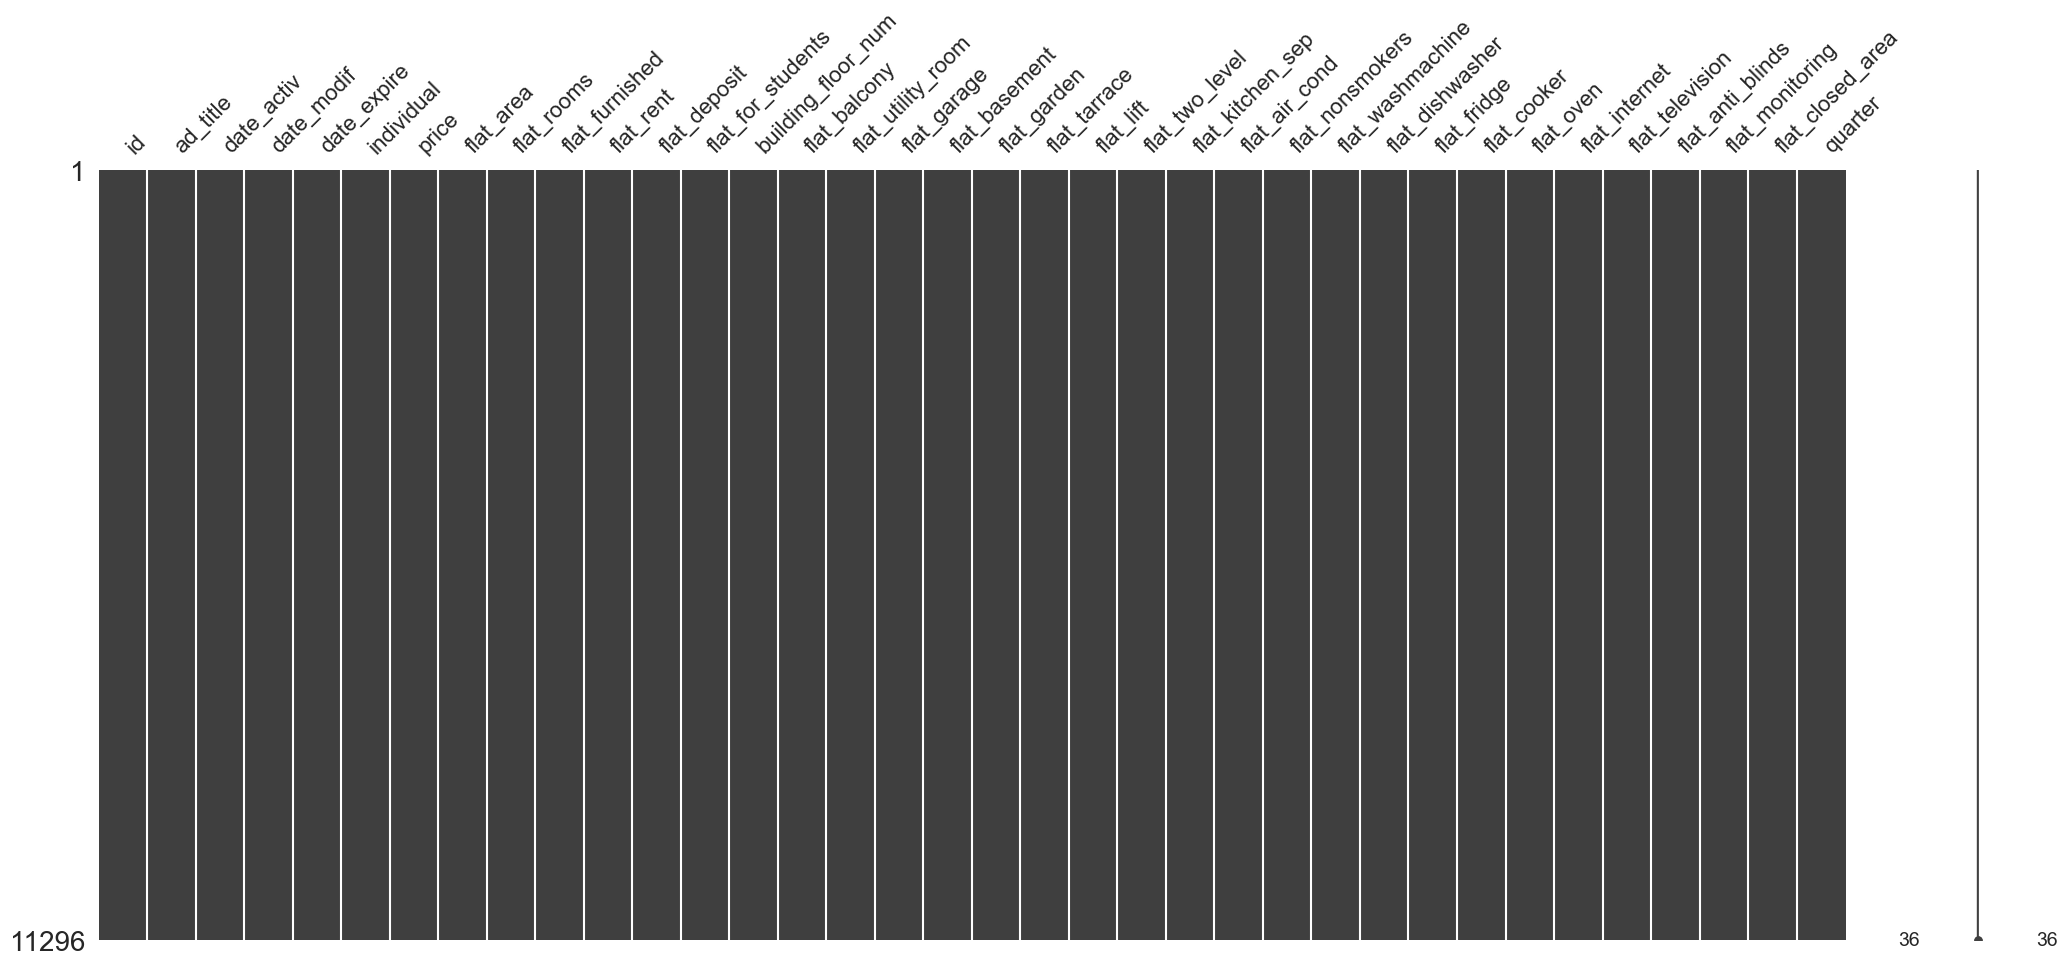

In [ ]:
msno.matrix(train)
plt.show()

In [ ]:
print(train['quarter'].unique())

['Rataje' 'Piątkowo' 'Wilda' 'Strzeszyn' 'Winogrady' 'Centrum' 'Łazarz'
 'Komandoria' 'Grunwald' 'Raszyn' 'Marcelin' 'Malta' 'Jeżyce' 'Podolany'
 'Rynek Wildecki' 'Sołacz' 'Górna Wilda' 'Górczyn' 'Stare Miasto'
 'Nowe Miasto' 'Rynek Łazarski' 'Garbary' 'Dębiec' 'Chartowo'
 'Stary Rynek' 'Marlewo' 'Naramowice' 'Winiary' 'Umultowo' 'Pogodno'
 'Ogrody' 'Junikowo' 'Kobyle Pole' 'Dolna Wilda' 'Świerczewo' 'Wilczak'
 'Warszawskie' 'Zawady' 'Chwaliszewo' 'Żegrze' 'Starołęka' 'Piekary'
 'Krzyżowniki' 'Zieliniec' 'Główna' 'Naramowickie Osiedle' 'Wola'
 'Rynek Jeżycki' 'Karolin' 'Ławica' 'Ostrów Tumski' 'Nadolnik' 'Fabianowo'
 'Krzesiny' 'Radojewo' 'Smochowice' 'Morasko' 'Starołęka Mała' 'Śródka'
 'Bonin' 'Piotrowo' 'Święty Roch' 'Biała Góra' 'Antoninek' 'Spławie'
 'Minikowo' 'Edwardowo' 'Strzeszynek' 'Franowo' 'Pokrzywno' 'Wilczy Młyn'
 'Czekalskie' 'Kopanina' 'Kotowo' 'Szczepankowo' 'Szeląg' 'Głuszyna'
 'Bajkowe']


In [ ]:
print(train.isna().sum())

id                    0
ad_title              0
date_activ            0
date_modif            0
date_expire           0
individual            0
price                 0
flat_area             0
flat_rooms            0
flat_furnished        0
flat_rent             0
flat_deposit          0
flat_for_students     0
building_floor_num    0
flat_balcony          0
flat_utility_room     0
flat_garage           0
flat_basement         0
flat_garden           0
flat_tarrace          0
flat_lift             0
flat_two_level        0
flat_kitchen_sep      0
flat_air_cond         0
flat_nonsmokers       0
flat_washmachine      0
flat_dishwasher       0
flat_fridge           0
flat_cooker           0
flat_oven             0
flat_internet         0
flat_television       0
flat_anti_blinds      0
flat_monitoring       0
flat_closed_area      0
quarter               0
dtype: int64


In [ ]:
def get_embedded_df(df, columns_to_embed, model_name='all-MiniLM-L6-v2'):
    """
    Tworzy embeddingi tekstowe z wybranych kolumn używając SentenceTransformer.
    Zwraca DataFrame z dodaną kolumną 'embeddings'.
    """
    model = SentenceTransformer(model_name)
    combined_text = df[columns_to_embed].astype(str).agg(' '.join, axis=1)
    embeddings = model.encode(combined_text.tolist(), show_progress_bar=True)
    
    df_embedded = df.copy()
    df_embedded['embeddings'] = list(embeddings)
    return df_embedded

In [ ]:
columns_to_embed = ['ad_title']

In [ ]:
train = get_embedded_df(train, columns_to_embed)
test = get_embedded_df(test, columns_to_embed)

Batches: 100%|██████████| 152/152 [00:02<00:00, 66.74it/s]


In [ ]:
train.drop(columns=['id', 'ad_title'], inplace=True)

In [ ]:
train = train.astype({'date_activ':'str', 'date_modif':'str', 'date_expire':'str',
       'individual':'bool', 'price':'float64', 'flat_area':'float64', 'flat_rooms':'float64', 'flat_furnished':'bool',
       'flat_rent':'float64', 'flat_deposit':'float64', 'flat_for_students':'bool', 'building_floor_num':'float64',
       'flat_balcony':'bool', 'flat_utility_room':'bool', 'flat_garage':'bool', 'flat_basement':'bool',
       'flat_garden':'bool', 'flat_tarrace':'bool', 'flat_lift':'bool', 'flat_two_level':'bool',
       'flat_kitchen_sep':'bool', 'flat_air_cond':'bool', 'flat_nonsmokers':'bool',
       'flat_washmachine':'bool', 'flat_dishwasher':'bool', 'flat_fridge':'bool', 'flat_cooker':'bool',
       'flat_oven':'bool', 'flat_internet':'bool', 'flat_television':'bool', 'flat_anti_blinds':'bool',
       'flat_monitoring':'bool', 'flat_closed_area':'bool', 'quarter':'str'})

In [ ]:
test = test.astype({'date_activ':'str', 'date_modif':'str', 'date_expire':'str',
       'individual':'bool', 'flat_area':'float64', 'flat_rooms':'float64', 'flat_furnished':'bool',
       'flat_rent':'float64', 'flat_deposit':'float64', 'flat_for_students':'bool', 'building_floor_num':'float64',
       'flat_balcony':'bool', 'flat_utility_room':'bool', 'flat_garage':'bool', 'flat_basement':'bool',
       'flat_garden':'bool', 'flat_tarrace':'bool', 'flat_lift':'bool', 'flat_two_level':'bool',
       'flat_kitchen_sep':'bool', 'flat_air_cond':'bool', 'flat_nonsmokers':'bool',
       'flat_washmachine':'bool', 'flat_dishwasher':'bool', 'flat_fridge':'bool', 'flat_cooker':'bool',
       'flat_oven':'bool', 'flat_internet':'bool', 'flat_television':'bool', 'flat_anti_blinds':'bool',
       'flat_monitoring':'bool', 'flat_closed_area':'bool', 'quarter':'str'})

In [ ]:
# Podział dat na osobne kolumny (rok, miesiąc, dzień)
train[['year_activ', 'month_activ', 'day_activ']] = train['date_activ'].str.split("-", expand=True)
train[['year_modif', 'month_modif', 'day_modif']] = train['date_modif'].str.split("-", expand=True)
train[['year_expire', 'month_expire', 'day_expire']] = train['date_expire'].str.split("-", expand=True)

In [ ]:
# Podział dat na osobne kolumny (rok, miesiąc, dzień)
test[['year_activ', 'month_activ', 'day_activ']] = test['date_activ'].str.split("-", expand=True)
test[['year_modif', 'month_modif', 'day_modif']] = test['date_modif'].str.split("-", expand=True)
test[['year_expire', 'month_expire', 'day_expire']] = test['date_expire'].str.split("-", expand=True)

In [ ]:
for col in ['date_expire', 'date_activ', 'date_modif']:
    train[col] = pd.to_datetime(train[col], errors='coerce')

In [ ]:
for col in ['date_expire', 'date_activ', 'date_modif']:
    test[col] = pd.to_datetime(test[col], errors='coerce')

In [ ]:
for df in [train, test]:
    date_part_cols = [
        "year_activ", "month_activ", "day_activ",
        "year_modif", "month_modif", "day_modif",
        "year_expire", "month_expire", "day_expire",
    ]
    # Konwersja timedelta na dni (float)
    for col in date_part_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

In [ ]:
# Tworzenie cech czasowych (różnice między datami)
train['time_active'] = train['date_expire'] - train['date_activ']
train['modif_before_expiry'] = train['date_expire'] - train['date_modif']
train['modif_after_activ'] = train['date_modif'] - train['date_activ']

In [ ]:
# Tworzenie cech czasowych (różnice między datami)
test['time_active'] = test['date_expire'] - test['date_activ']
test['modif_before_expiry'] = test['date_expire'] - test['date_modif']
test['modif_after_activ'] = test['date_modif'] - test['date_activ']

In [ ]:

for df in [train, test]:
    td_cols = df.select_dtypes(include="timedelta64[ns]").columns

    for col in td_cols:
        df[col + "_days"] = df[col].dt.days.astype("float64")

    df.drop(columns=td_cols, inplace=True)

print("Timedelta columns in train:", train.select_dtypes(include="timedelta64[ns]").columns.tolist())
print("Timedelta columns in test:",  test.select_dtypes(include="timedelta64[ns]").columns.tolist())


Timedelta columns in train: []
Timedelta columns in test: []


In [ ]:
def expand_embedding_column(df, col_name="embedding", prefix="emb_"):
    """
    df[col_name] must contain same-length lists/arrays for each row.
    Returns a new DataFrame with one column per embedding dimension.
    """
    # Convert the column to a 2D numpy array (n_rows x dim)
    emb_array = np.vstack(df[col_name].values)

    # Create column names: emb_0, emb_1, ...
    dim = emb_array.shape[1]
    emb_cols = [f"{prefix}{i}" for i in range(dim)]

    # Build a DataFrame from the array
    emb_df = pd.DataFrame(emb_array, columns=emb_cols, index=df.index)

    # Option 1: concatenate and drop original
    df_out = pd.concat([df.drop(columns=[col_name]), emb_df], axis=1)
    return df_out

In [ ]:
train = expand_embedding_column(train, col_name="embeddings")
test = expand_embedding_column(test, col_name="embeddings")

In [ ]:
# Obcinanie wartości odstających do percentyli 1% i 99%
for col in ['price']:
    upper = train[col].quantile(0.99)
    lower = train[col].quantile(0.01)
    train[col] = train[col].clip(lower, upper)

In [ ]:
# Obcinanie wartości odstających do percentyli 1% i 99%
for col in ['flat_rent', 'flat_deposit']:
    upper = train[col].quantile(0.99)
    lower = train[col].quantile(0.01)
    train[col] = train[col].clip(lower, upper)
    test[col] = test[col].clip(lower, upper)

In [ ]:
train.drop(columns=['date_activ', 'date_modif', 'date_expire'], inplace=True)
test.drop(columns=['date_activ', 'date_modif', 'date_expire'], inplace=True)

In [ ]:
X_train = train.drop(columns=['price']).copy()
y_train = train['price'].copy()
X_test = test.drop(columns=['id', 'ad_title']).copy()

In [ ]:
X_train = pd.get_dummies(X_train, columns=['quarter'])
X_test = pd.get_dummies(X_test, columns=['quarter'])

In [ ]:
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"

In [ ]:
models = {
    "LinearRegression": (
        LinearRegression(),
        {"fit_intercept": [True, False], "positive": [False]},
    ),
    
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": [200, 400],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 5],
            "max_features": ["sqrt", "log2"],
        },
    ),
    
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "n_estimators": [200, 400],
            "learning_rate": [0.05, 0.1],
            "max_depth": [2, 3],
            "min_samples_leaf": [1, 5],
            "subsample": [0.8, 1.0],
        },
    ),
    
    "GradientBoosting_log_target": (
        TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(random_state=42),
            func=np.log1p,
            inverse_func=np.expm1,
        ),
        {
            "regressor__n_estimators": [200, 400],
            "regressor__learning_rate": [0.03, 0.05, 0.1],
            "regressor__max_depth": [2, 3],
            "regressor__min_samples_leaf": [1, 5],
            "regressor__subsample": [0.8, 1.0],
        },
    ),
    
    "KNN": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [3, 5, 10],
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
    )
}

In [ ]:
'''
results = {}

for name, (estimator, param_grid) in models.items():

    uses_log_target = "log_target" in name.lower()
    
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,   
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    best_mse = -grid.best_score_        
    best_rmse = np.sqrt(best_mse)
    
    results[name] = {
        "best_params": grid.best_params_,
        "best_mse_cv": best_mse,
        "best_rmse_cv": best_rmse,
        "uses_log_target": uses_log_target,
    }
    
    print(f"\n{name}{' (log1p target)' if uses_log_target else ''}")
    print("  Best params:", grid.best_params_)
    print(f"  Best CV MSE (price):  {best_mse:.4f}")
    print(f"  Best CV RMSE (price): {best_rmse:.4f}")
'''

'\nresults = {}\n\nfor name, (estimator, param_grid) in models.items():\n\n    uses_log_target = "log_target" in name.lower()\n\n    grid = GridSearchCV(\n        estimator=estimator,\n        param_grid=param_grid,\n        scoring=scoring,   \n        cv=cv,\n        n_jobs=-1,\n        verbose=1\n    )\n\n    grid.fit(X_train, y_train)\n\n    best_mse = -grid.best_score_        \n    best_rmse = np.sqrt(best_mse)\n\n    results[name] = {\n        "best_params": grid.best_params_,\n        "best_mse_cv": best_mse,\n        "best_rmse_cv": best_rmse,\n        "uses_log_target": uses_log_target,\n    }\n\n    print(f"\n{name}{\' (log1p target)\' if uses_log_target else \'\'}")\n    print("  Best params:", grid.best_params_)\n    print(f"  Best CV MSE (price):  {best_mse:.4f}")\n    print(f"  Best CV RMSE (price): {best_rmse:.4f}")\n'

In [ ]:
models2 = {
    "XGB": (
        XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=42,
            n_estimators=1000,
            n_jobs=-1,
            eval_metric="rmse",
        ),
        {
            "max_depth": [4, 6, 8],
            "learning_rate": [0.03, 0.05, 0.1],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0],
            "min_child_weight": [1, 5, 10],
        },
    ),
    
    "XGB_log_target": (
        TransformedTargetRegressor(
            regressor=XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                random_state=42,
                n_estimators=1000,
                n_jobs=-1,
                eval_metric="rmse",
            ),
            func=np.log1p,
            inverse_func=np.expm1,
        ),
        {
            "regressor__max_depth": [4, 6, 8],
            "regressor__learning_rate": [0.03, 0.05, 0.1],
            "regressor__subsample": [0.7, 0.9, 1.0],
            "regressor__colsample_bytree": [0.7, 0.9, 1.0],
            "regressor__min_child_weight": [1, 5, 10],
        },
    ),
    
    "LightGBM": (
        lgb.LGBMRegressor(
            objective="regression",
            boosting_type="gbdt",
            random_state=42,
            n_jobs=-1,
            n_estimators=1000,
            verbose=-1,
        ),
        {
            "num_leaves": [31, 63, 127],
            "max_depth": [-1, 5, 7],
            "learning_rate": [0.03, 0.05, 0.1],
            "subsample": [0.7, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.9, 1.0],
            "min_child_samples": [10, 20, 50],
        },
    ),
    
    "LightGBM_log_target": (
        TransformedTargetRegressor(
            regressor=lgb.LGBMRegressor(
                objective="regression",
                boosting_type="gbdt",
                random_state=42,
                n_jobs=-1,
                n_estimators=1000,
                verbose=-1,
            ),
            func=np.log1p,
            inverse_func=np.expm1,
        ),
        {
            "regressor__num_leaves": [31, 63, 127],
            "regressor__max_depth": [-1, 5, 7],
            "regressor__learning_rate": [0.03, 0.05, 0.1],
            "regressor__subsample": [0.7, 0.9, 1.0],
            "regressor__colsample_bytree": [0.7, 0.9, 1.0],
            "regressor__min_child_samples": [10, 20, 50],
        },
    ),
}

In [ ]:
'''
results2 = {}

for name, (estimator, param_dist) in models2.items():
    uses_log_target = "log_target" in name.lower()

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=10,                
        scoring=scoring,          
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=42,
    )

    search.fit(X_train, y_train)

    best_mse = -search.best_score_
    best_rmse = np.sqrt(best_mse)

    results2[name] = {
        "best_params": search.best_params_,
        "best_mse_cv": best_mse,
        "best_rmse_cv": best_rmse,
        "uses_log_target": uses_log_target,
    }

    print(f"\n{name}{' (log1p target)' if uses_log_target else ''}")
    print("  Best params:", search.best_params_)
    print(f"  Best CV MSE (price):  {best_mse:.4f}")
    print(f"  Best CV RMSE (price): {best_rmse:.4f}")
'''

'\nresults2 = {}\n\nfor name, (estimator, param_dist) in models2.items():\n    uses_log_target = "log_target" in name.lower()\n\n    search = RandomizedSearchCV(\n        estimator=estimator,\n        param_distributions=param_dist,\n        n_iter=10,                \n        scoring=scoring,          \n        cv=cv,\n        n_jobs=-1,\n        verbose=1,\n        random_state=42,\n    )\n\n    search.fit(X_train, y_train)\n\n    best_mse = -search.best_score_\n    best_rmse = np.sqrt(best_mse)\n\n    results2[name] = {\n        "best_params": search.best_params_,\n        "best_mse_cv": best_mse,\n        "best_rmse_cv": best_rmse,\n        "uses_log_target": uses_log_target,\n    }\n\n    print(f"\n{name}{\' (log1p target)\' if uses_log_target else \'\'}")\n    print("  Best params:", search.best_params_)\n    print(f"  Best CV MSE (price):  {best_mse:.4f}")\n    print(f"  Best CV RMSE (price): {best_rmse:.4f}")\n'

In [ ]:
models3 = {
    "XGB": (
        XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=42,
            n_estimators=1000,
            n_jobs=-1,
            eval_metric="rmse",
        ),
        {
            "max_depth": [5, 6],
            "learning_rate": [0.02, 0.03],
            "subsample": [0.8, 0.9],
            "colsample_bytree": [0.9, 1.0],
            "min_child_weight": [3, 5],
        },
    ),

    "XGB_log_target": (
        TransformedTargetRegressor(
            regressor=XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                random_state=42,
                n_estimators=1000,
                n_jobs=-1,
                eval_metric="rmse",
            ),
            func=np.log1p,
            inverse_func=np.expm1,
        ),
        {
            "regressor__max_depth": [5, 6],
            "regressor__learning_rate": [0.02, 0.03],
            "regressor__subsample": [0.8, 0.9],
            "regressor__colsample_bytree": [0.9, 1.0],
            "regressor__min_child_weight": [3, 5],
        },
    ),

    "LightGBM": (
        lgb.LGBMRegressor(
            objective="regression",
            boosting_type="gbdt",
            random_state=42,
            n_jobs=-1,
            n_estimators=1000,
            verbose=-1,
        ),
        {
            "num_leaves": [63, 95],
            "max_depth": [6, 7],
            "learning_rate": [0.03, 0.05],
            "subsample": [0.8, 0.9],
            "colsample_bytree": [0.7, 0.9],
            "min_child_samples": [20, 30],
        },
    ),

    "LightGBM_log_target": (
        TransformedTargetRegressor(
            regressor=lgb.LGBMRegressor(
                objective="regression",
                boosting_type="gbdt",
                random_state=42,
                n_jobs=-1,
                n_estimators=1000,
                verbose=-1,
            ),
            func=np.log1p,
            inverse_func=np.expm1,
        ),
        {
            "regressor__num_leaves": [63, 95],
            "regressor__max_depth": [-1, 7],
            "regressor__learning_rate": [0.02, 0.03],
            "regressor__subsample": [0.9, 1.0],
            "regressor__colsample_bytree": [0.8, 0.9],
            "regressor__min_child_samples": [30, 50],
        },
    ),
}


In [ ]:
'''
results3 = {}

for name, (estimator, param_grid) in models3.items():
    uses_log_target = "log_target" in name.lower()
    
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    
    grid.fit(X_train, y_train)
    
    best_mse = -grid.best_score_
    best_rmse = np.sqrt(best_mse)
    
    results3[name] = {
        "best_params": grid.best_params_,
        "best_mse_cv": best_mse,
        "best_rmse_cv": best_rmse,
        "uses_log_target": uses_log_target,
    }
    
    print(f"\n{name}{' (log1p target)' if uses_log_target else ''}")
    print("  Best params:", grid.best_params_)
    print(f"  Best CV MSE (price):  {best_mse:.4f}")
    print(f"  Best CV RMSE (price): {best_rmse:.4f}")
'''

'\nresults3 = {}\n\nfor name, (estimator, param_grid) in models3.items():\n    uses_log_target = "log_target" in name.lower()\n\n    grid = GridSearchCV(\n        estimator=estimator,\n        param_grid=param_grid,\n        scoring="neg_mean_squared_error",\n        cv=cv,\n        n_jobs=-1,\n        verbose=1,\n    )\n\n    grid.fit(X_train, y_train)\n\n    best_mse = -grid.best_score_\n    best_rmse = np.sqrt(best_mse)\n\n    results3[name] = {\n        "best_params": grid.best_params_,\n        "best_mse_cv": best_mse,\n        "best_rmse_cv": best_rmse,\n        "uses_log_target": uses_log_target,\n    }\n\n    print(f"\n{name}{\' (log1p target)\' if uses_log_target else \'\'}")\n    print("  Best params:", grid.best_params_)\n    print(f"  Best CV MSE (price):  {best_mse:.4f}")\n    print(f"  Best CV RMSE (price): {best_rmse:.4f}")\n'

In [ ]:
submission_ids = pd.read_csv("data/pzn-sample-sub.csv")["ID"]

Tylko najlepszy model zostawiony nie-okomentowany dla optymalizacji kodu

In [ ]:
# model = XGBRegressor(
#     objective="reg:squarederror",
#     tree_method="hist",
#     n_estimators=1000,

#     colsample_bytree=1.0,
#     learning_rate=0.03,
#     max_depth=6,
#     min_child_weight=5,
#     subsample = 0.8,
#     random_state=2026,
#     n_jobs=-1,
# )

# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

# submission = pd.DataFrame({
#     "ID": submission_ids,
#     "TARGET": predictions
# })

# submission.to_csv("submissions/submissionXGB.csv", index=False)

In [ ]:
# model = TransformedTargetRegressor(
#     regressor=XGBRegressor(
#         objective="reg:squarederror",
#         tree_method="hist",
#         n_estimators=1000,
#         n_jobs=-1,

#         colsample_bytree=0.9,
#         learning_rate=0.03,
#         max_depth=6,
#         min_child_weight=3,
#         subsample=0.8,
#         random_state=2026,
#     ),
#     func=np.log1p,
#     inverse_func=np.expm1,
# )

# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

# submission = pd.DataFrame({
#     "ID": submission_ids,
#     "TARGET": predictions
# })

# submission.to_csv("submissions/submissionXGB_log.csv", index=False)

In [ ]:
# Model finalny: LightGBM z najlepszymi parametrami
model = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=2026,
    n_jobs=-1,
    n_estimators=1000,
    verbose=-1,
    num_leaves=63,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_samples=20,
    )

model.fit(X_train, y_train)

predictions = model.predict(X_test)

submission = pd.DataFrame({
    "ID": submission_ids,
    "TARGET": predictions
})

submission.to_csv("submissions/submissionLightGBM.csv", index=False)

In [ ]:
# model = TransformedTargetRegressor(
#         regressor=lgb.LGBMRegressor(
#         objective="regression",
#         boosting_type="gbdt",
#         random_state=2026,
#         n_jobs=-1,
#         n_estimators=1000,
#         verbose=-1,
#         regressor__colsample_bytree=0.8,
#         regressor__learning_rate=0.03,
#         regressor__max_depth=-1,
#         regressor__min_child_samples=30,
#         regressor__subsample=0.9,
#         regressor__num_leaves=63
#     ),
#         func=np.log1p,
#         inverse_func=np.expm1,
# )

# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

# submission = pd.DataFrame({
#     "ID": submission_ids,
#     "TARGET": predictions
# })

# submission.to_csv("submissions/submissionLightGBM_log.csv", index=False)